# Simulation and Comparison of Our Method with Other Methods

## 1. Graph System Identification (GSI) from paper [Graph Learning From Filtered Signals: Graph System and Diffusion Kernel Identification](https://arxiv.org/pdf/1803.02553.pdf)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import scipy.io
import collections
from collections import defaultdict 

import os
import sys
sys.path.append('/Users/apple/Desktop/graph_learning/FilterLearning/src')

from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, recall_score, precision_score

import generators as gen
import optimize as opt
import helpers as hel
import pickle as pkl
from NNet import NNet
from networkx.generators.community import stochastic_block_model


%load_ext autoreload
%autoreload 2

In [2]:
os.getcwd()

'/home/farsijan/graph_learning'

In [3]:
def gen_samples(L, n_samples=500):
    """Reproducibly generates 500 samples from L."""
    if type(L) is not torch.Tensor:
        L = torch.Tensor(L)
    
    samples = gen.gen_white_noise(n_samples, L.shape[0], random_state=None)
    return samples

# generate graphs
def generate_L_sbm(nnodes=10, p_in=.8, p_out=.1, seed=42, n_blocks=2):
    """generates Laplacian of stochastic block model with 2 clusters, with nnodes."""
    if n_blocks==2:
        G = stochastic_block_model([nnodes//2,nnodes//2],[[p_in,p_out],[p_out,p_in]], seed=seed)
        A = nx.adjacency_matrix(G).todense()
        L = nx.laplacian_matrix(G).todense()  
    else:
        prob_matrix = np.eye(n_blocks)*(p_in-p_out) + p_out
        G = stochastic_block_model([nnodes//n_blocks]*n_blocks, prob_matrix, seed=seed)  
        A = nx.adjacency_matrix(G).todense()          
        L = nx.laplacian_matrix(G).todense()
    samples = gen_samples(L,n_samples=500)
    return  L, A

def create_multiple_graphs(n_graphs=20, **kwargs):
    return [generate_L_sbm(seed=i, **kwargs) for i in range(n_graphs)]

def to_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pkl.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

In [4]:
create_new = False
if create_new==True:
    res_30 = create_multiple_graphs(20, nnodes=45, p_in=.3, p_out=.1, n_blocks=3)
    As_30 = [i[1] for i in res_30]
    Ls_30 = [i[0] for i in res_30]
    to_pickle(Ls_30, 'GSI/data/Ls_30.pkl')
    to_pickle(As_30, 'GSI/data/As_30.pkl')
    scipy.io.savemat('GSI/mat_files/As_30.mat', mdict={'As': As_30})
    scipy.io.savemat('GSI/mat_files/Ls_30.mat', mdict={'Ls': Ls_30})


    res_50 = create_multiple_graphs(20, nnodes=45, p_in=.5, p_out=.1, n_blocks=3)
    As_50 = [i[1] for i in res_50]
    Ls_50 = [i[0] for i in res_50]
    to_pickle(Ls_50, 'GSI/data/Ls_50.pkl')
    to_pickle(As_50, 'GSI/data/As_50.pkl')
    scipy.io.savemat('GSI/mat_files/Ls_50.mat', mdict={'Ls': Ls_50})
    scipy.io.savemat('GSI/mat_files/As_50.mat', mdict={'As': As_50})


    res_70 = create_multiple_graphs(20, nnodes=45, p_in=.7, p_out=.1, n_blocks=3)
    As_70 = [i[1] for i in res_70]
    Ls_70 = [i[0] for i in res_70]
    to_pickle(Ls_70, 'GSI/data/Ls_70.pkl')
    to_pickle(As_70, 'GSI/data/As_70.pkl')
    scipy.io.savemat('GSI/mat_files/Ls_70.mat', mdict={'Ls': Ls_70})
    scipy.io.savemat('GSI/mat_files/As_70.mat', mdict={'As': As_70})



In [5]:
def load_saved_Ls():
    all_list = [Ls_30,Ls_50,Ls_70,As_30,As_50,As_70]
    all_list_str = ['Ls_30','Ls_50','Ls_70','As_30','As_50','As_70']
    for l,l_str in zip(all_list,all_list_str):
        l = from_pickel(l_str)


In [6]:
def sample_kernel(L, ker, n_samples=500):
    """Reproducibly generates 500 samples from L using kernel ker, then 
    imputes a graph using the imputer. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    
    samples = gen.gen_and_filter(L, n_samples, ker=ker, seed=42)
    return samples.squeeze().tolist() 


def generate_samples(Ls, ker, verbose=True):
    """For every L in Ls, generates samples with ker and imputes the graph
    using the imputer method. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    out = []
    for i, L in enumerate(Ls):
        if verbose:
            print('\rGenerating sample {}'.format(i+1), end=' ')
        out.append(sample_kernel(L, ker))
    return out

def f1_scores(Ls, imps):
    """Calculates f1 scores between lists"""
    return [f1_score(np.asarray(L<0).flatten(),(imp<0).flatten()) for L, imp in zip(Ls, imps)]

def precision_scores(Ls, imps):
    """Calculates precision scores between lists"""
    return [precision_score(np.asarray(L<0).flatten(),(imp<0).flatten()) for L, imp in zip(Ls, imps)]

def recall_scores(Ls, imps):
    """Calculates recall scores between lists"""
    return [recall_score(np.asarray(L<0).flatten(),(imp<0).flatten()) for L, imp in zip(Ls, imps)]

def accuracy_scores(Ls, imps):
    """Calculates accuracy scores for lists"""
    return [accuracy_score(np.asarray(L<0).flatten(),(imp<0).flatten(),normalize=True) for L, imp in zip(Ls, imps)]

def mae_scores(Ls, imps):
    """Calculates mean absolute error for lists"""
    return [mean_absolute_error(np.asarray(L).flatten(),(imp).flatten()) for L, imp in zip(Ls, imps)]

def process_samples(savefile_prefix):
    kerlist = [gen.kernel_heat, gen.kernel_normal, 
               lambda x: gen.kernel_highpass(x, par=.5)]
    kernames = ['heat', 'norm', 'high']
    
    Lslist = [Ls_30, Ls_50, Ls_70]
    Lsnames = ['30', '50', '70']
    
    for ker, kername in zip(kerlist, kernames):
        print('Kernel:', kername)
        
        for Ls, Lsname in zip(Lslist, Lsnames):
            print('Ls:', Lsname)
            
            samples = generate_samples(Ls, ker)

            savefile_suffix = '_' + Lsname + '_' + kername + '.pkl'
            to_pickle(samples, savefile_prefix + Lsname + '_' + kername + '.pkl')
            scipy.io.savemat('/SCRATCH2/farsijan/graph_learning/GSI/mat_files/samples_'+ Lsname + '_' + kername + '.mat', mdict={'samples': samples})

        
        

In [7]:
#process_samples('GSI/data/samples_')

In [8]:
def load_Ls_As():
    Ls_list = []
    As_list = []
    type_list = ['Ls','As']
    algs = ['GSI', 'CGL', 'GGL','DDGL']
    Ls_names = ['30','50','70']
    ker_names = ['heat','norm','high']
    for t in type_list:
        for L in Ls_names:
            filename = ('/SCRATCH2/farsijan/graph_learning/GSI/data/'+ t +'_' + L + '.pkl')
            with open(filename, 'rb') as f:
                if t == 'Ls':
                    Ls_list.append(pkl.load(f))
                else:
                    As_list.append(pkl.load(f))
    return Ls_list, As_list    

In [9]:
Ls_list, As_list = load_Ls_As()

In [10]:
Ls_30 = Ls_list[0]
Ls_50 = Ls_list[1]
Ls_70 = Ls_list[2]

As_30 = As_list[0]
As_50 = As_list[1]
As_70 = As_list[2]

In [11]:
def plot_data(data,title):
    fig, axs = plt.subplots(4,5)
    fig.suptitle(title)
    k = 0
    for i in range(4):
        for j in range(5):
            axs[i, j].imshow(data[k])
            k+=1

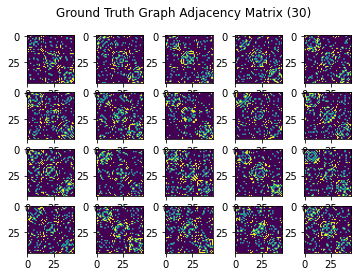

In [12]:
plot_data(As_30,'Ground Truth Graph Adjacency Matrix (30)')

# Our Method

In [13]:
our_imputer = lambda x: opt.impute_graph(x, lr=.01, verbose=False,
                                         n_epochs=3000, lr_nnet=1e-3, nit_nnet=3)[0]>.5

In [14]:
def load_samples():
    samples_dict = {}
    type_list = ['Ls','As']
    algs = ['GSI', 'CGL', 'GGL','DDGL']
    Ls_list = ['30','50','70']
    ker_list = ['heat','norm','high']
    #for t in type_list:
    for L in Ls_list:
        for ker in ker_list:
            for alg in algs:
                filename = ('/SCRATCH2/farsijan/graph_learning/GSI/data/samples_' + L +'_' + ker + '.pkl')
                with open(filename, 'rb') as f:
                    samples_dict[L +'_' + ker] = pkl.load(f)
    return samples_dict

In [15]:
samples_dict = load_samples()

In [16]:
def impute_with_our_method(samples_dict, imputer, verbose=True):
    """For every imputer takes samples and returns an adjacency matrix."""
    out = defaultdict(list) 
    for k,v in samples_dict.items():
        for i in range(len(v)):
            if verbose:
                print('\r Imputing sample {}'.format(k), end=' ')
                out['Ls_' + k + 'kernel_our'].append(imputer(np.asarray(v[i])))
    to_pickle(out,'/SCRATCH2/farsijan/graph_learning/GSI/data/res_our_final.pkl')
    return out

In [17]:
#our_results = impute_with_our_method(samples_dict,our_imputer)

In [18]:
#our_results.keys()

In [19]:
our_As_dict = from_pickle('/SCRATCH2/farsijan/graph_learning/GSI/data/res_our_final.pkl') # load results

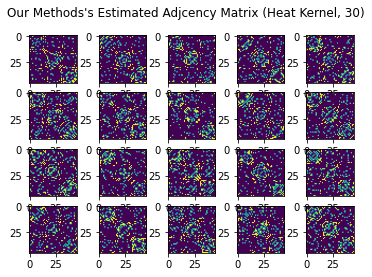

In [20]:
plot_data(our_As_dict['Ls_30_heatkernel_our'], 'Our Methods\'s Estimated Adjcency Matrix (Heat Kernel, 30)')

Convert our As to Ls:

In [21]:
our_Ls_dict = {}
for k,v in our_As_dict.items():
    our_Ls_dict[k] = hel.A_to_L(np.asarray(our_As_dict[k]))

# GSI and GCL

Use data saved in 'GSI/mat_files' and run algorithm in MATLAB (/GSI/start_graph_learning.m). Then run the rest of this notebook. 

In [22]:
def load_mat_files():
    all_mat_dict = {}
    type_list = ['Ls','As']
    algs = ['GSI', 'CGL', 'GGL','DDGL']
    Ls_list = ['30','50','70']
    ker_list = ['heat','norm','high']
    for t in type_list:
        for L in Ls_list:
            for ker in ker_list:
                for alg in algs:
                    loaded_dict = scipy.io.loadmat('/SCRATCH2/farsijan/graph_learning/GSI/mat_files/' + t + '_' + L +'_' + ker + 'kernel' + '_' + alg + '_res.mat')
                    loaded = loaded_dict[t + '_'+ alg + '_est']   
                    all_mat_dict[t + '_' + L +'_' + ker + 'kernel' + '_' + alg] = loaded
    return all_mat_dict

In [23]:
all_mat_dict = load_mat_files()
#(all_mat_dict).keys()

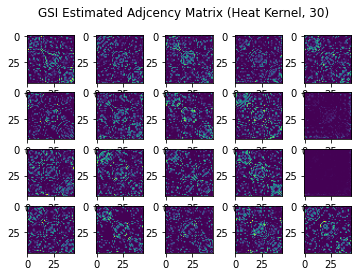

In [24]:
plot_data(all_mat_dict['As_30_heatkernel_GSI'], 'GSI Estimated Adjcency Matrix (Heat Kernel, 30)')

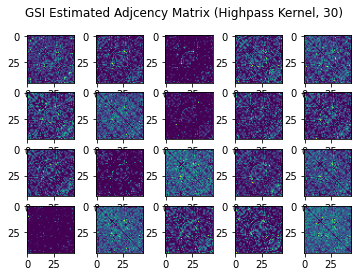

In [25]:
plot_data(all_mat_dict['As_30_highkernel_GSI'],'GSI Estimated Adjcency Matrix (Highpass Kernel, 30)')

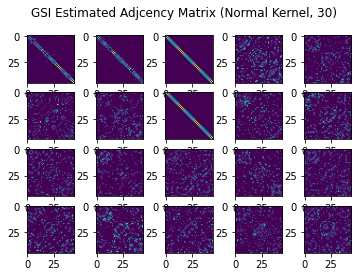

In [26]:
plot_data(all_mat_dict['As_30_normkernel_GSI'],'GSI Estimated Adjcency Matrix (Normal Kernel, 30)')

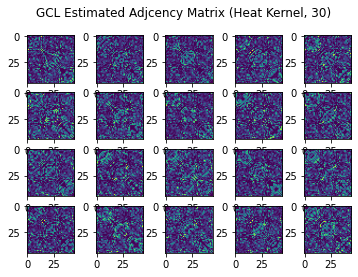

In [27]:
plot_data(all_mat_dict['As_30_heatkernel_CGL'],'GCL Estimated Adjcency Matrix (Heat Kernel, 30)')

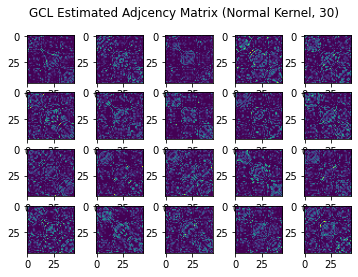

In [28]:
plot_data(all_mat_dict['As_30_normkernel_CGL'],'GCL Estimated Adjcency Matrix (Normal Kernel, 30)')

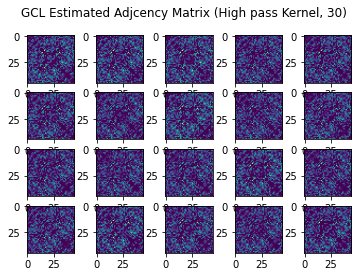

In [29]:
plot_data(all_mat_dict['As_30_highkernel_CGL'],'GCL Estimated Adjcency Matrix (High pass Kernel, 30)')

## Comapre and Plot Results 

In [30]:
def calculate_scores(data_dict,Lslist):
    kernames = ['heat', 'norm', 'high']
    algs = ['our','GSI','CGL','GGL','DDGL']
    Lsnames = ['30', '50', '70']
    f1_dict = {} 
    precision_dict = {}
    recall_dict = {}
    acc_dict = {}  
    mae_dict = {}
    for alg in algs: 
        print('Algorithm:', alg)
        for Ls, Lsname in zip(Lslist, Lsnames):
            for ker in kernames:
                f1_dict[Lsname + '_' + ker + '_' + alg]= f1_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                precision_dict[Lsname + '_' + ker + '_' + alg]= precision_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                recall_dict[Lsname + '_' + ker + '_' + alg]= recall_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                acc_dict[Lsname + '_' + ker + '_' + alg] = accuracy_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
                mae_dict[Lsname + '_' + ker + '_' + alg] = mae_scores(Ls, np.asarray(data_dict['Ls_' + Lsname +'_' + ker + 'kernel' + '_' + alg]))
    return f1_dict, precision_dict, recall_dict, acc_dict, mae_dict

Combine all results:

In [31]:
all_data_dict = {**all_mat_dict, **our_Ls_dict}

In [32]:
f1_dict, precision_dict, recall_dict, acc_dict, mae_dict = calculate_scores(all_data_dict,[Ls_30, Ls_50, Ls_70])

Algorithm: our
Algorithm: GSI
Algorithm: CGL
Algorithm: GGL
Algorithm: DDGL


Calculate the average f1-score,  avg accuracy score, and MAE values of each algorithm for each type of kernel:

In [33]:
def score_avg(data):
    Lslist = ['30', '50', '70']
    kernames = ['heat', 'norm', 'high']
    algs = ['our','GSI','CGL','GGL','DDGL']
    Lsnames = ['30', '50', '70']
    avg=collections.defaultdict(dict)
    for kername in kernames:
        for alg in algs:
            avg[kername][alg] = {}
            for L in  Lslist:
                avg[kername][alg][L]= np.mean(data[L + '_' + kername + '_' + alg]) # for L in Lslist])
    return avg

In [34]:
f1_avg = score_avg(f1_dict)
f1_avg

defaultdict(dict,
            {'heat': {'our': {'30': 0.966161511389729,
               '50': 0.9606198680774691,
               '70': 0.9708717507129879},
              'GSI': {'30': 0.6264806736922355,
               '50': 0.8940375650004659,
               '70': 0.9042133471101639},
              'CGL': {'30': 0.34324391726675385,
               '50': 0.4168379156684757,
               '70': 0.4713400973751248},
              'GGL': {'30': 0.5390471363355371,
               '50': 0.5909155959237536,
               '70': 0.6104159192294518},
              'DDGL': {'30': 0.5390471363355371,
               '50': 0.5909155959237536,
               '70': 0.6104159192294518}},
             'norm': {'our': {'30': 0.7646654559659285,
               '50': 0.8050544922464592,
               '70': 0.7439850519239258},
              'GSI': {'30': 0.6698171151576497,
               '50': 0.6663246643927451,
               '70': 0.6584313114218329},
              'CGL': {'30': 0.48430243668840955

In [35]:
precision_avg = score_avg(precision_dict)
precision_avg

defaultdict(dict,
            {'heat': {'our': {'30': 0.9909326959934439,
               '50': 0.9978115845022956,
               '70': 0.9994257693864249},
              'GSI': {'30': 0.4768740887459965,
               '50': 0.8462537655172845,
               '70': 0.9121626378668448},
              'CGL': {'30': 0.20736028177532678,
               '50': 0.2633865989745135,
               '70': 0.3084456213443243},
              'GGL': {'30': 0.3692624418391405,
               '50': 0.419408022488753,
               '70': 0.43935860231377266},
              'DDGL': {'30': 0.3692624418391405,
               '50': 0.419408022488753,
               '70': 0.43935860231377266}},
             'norm': {'our': {'30': 0.9681665698121018,
               '50': 0.8904491499664242,
               '70': 0.8993912334775661},
              'GSI': {'30': 0.5707472491620147,
               '50': 0.554708124631857,
               '70': 0.5847338550601578},
              'CGL': {'30': 0.3202311169960529,

In [36]:
recall_avg = score_avg(recall_dict)
recall_avg

defaultdict(dict,
            {'heat': {'our': {'30': 0.9433451812876805,
               '50': 0.9263448646381708,
               '70': 0.9439793493522274},
              'GSI': {'30': 0.9667225474272495,
               '50': 0.948847640775767,
               '70': 0.896910313725134},
              'CGL': {'30': 1.0, '50': 1.0, '70': 1.0},
              'GGL': {'30': 1.0, '50': 1.0, '70': 1.0},
              'DDGL': {'30': 1.0, '50': 1.0, '70': 1.0}},
             'norm': {'our': {'30': 0.6485372301515344,
               '50': 0.736329389898789,
               '70': 0.6378099024076438},
              'GSI': {'30': 0.8724961148267631,
               '50': 0.8436248102254643,
               '70': 0.7621428590548471},
              'CGL': {'30': 0.9962441283371504,
               '50': 0.9889615200756033,
               '70': 0.9832649573604456},
              'GGL': {'30': 0.9628119885575476,
               '50': 0.9110428535467134,
               '70': 0.8700312470027809},
             

In [37]:
acc_avg = score_avg(acc_dict)
acc_avg

defaultdict(dict,
            {'heat': {'our': {'30': 0.9896790123456791,
               '50': 0.9835061728395061,
               '70': 0.9842469135802471},
              'GSI': {'30': 0.8109135802469135,
               '50': 0.9510123456790124,
               '70': 0.9469629629629628},
              'CGL': {'30': 0.40044444444444444,
               '50': 0.3876049382716049,
               '70': 0.37209876543209874},
              'GGL': {'30': 0.7321481481481482,
               '50': 0.6961975308641974,
               '70': 0.6413827160493828},
              'DDGL': {'30': 0.7321481481481482,
               '50': 0.6961975308641974,
               '70': 0.6413827160493828}},
             'norm': {'our': {'30': 0.9416296296296295,
               '50': 0.9215308641975308,
               '70': 0.8774814814814814},
              'GSI': {'30': 0.8184691358024692,
               '50': 0.8090370370370369,
               '70': 0.7721481481481483},
              'CGL': {'30': 0.667851851851851

In [38]:
mae_avg = score_avg(acc_dict)
mae_avg

defaultdict(dict,
            {'heat': {'our': {'30': 0.9896790123456791,
               '50': 0.9835061728395061,
               '70': 0.9842469135802471},
              'GSI': {'30': 0.8109135802469135,
               '50': 0.9510123456790124,
               '70': 0.9469629629629628},
              'CGL': {'30': 0.40044444444444444,
               '50': 0.3876049382716049,
               '70': 0.37209876543209874},
              'GGL': {'30': 0.7321481481481482,
               '50': 0.6961975308641974,
               '70': 0.6413827160493828},
              'DDGL': {'30': 0.7321481481481482,
               '50': 0.6961975308641974,
               '70': 0.6413827160493828}},
             'norm': {'our': {'30': 0.9416296296296295,
               '50': 0.9215308641975308,
               '70': 0.8774814814814814},
              'GSI': {'30': 0.8184691358024692,
               '50': 0.8090370370370369,
               '70': 0.7721481481481483},
              'CGL': {'30': 0.667851851851851

Plot the average resutls for every algorithm:

In [39]:
def plot_results(data,y_title):
    algs = ['our','GSI','CGL']#,'DDGL','GGL']
    kernames = ['heat', 'norm', 'high']
    Lsnames = ['30', '50', '70']
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    for i,kernel in enumerate(kernames):
        for alg in algs:
            axs[i].set_title(kernel + ' kernel')
            axs[i].plot([30,50,70],list(data[kernel][alg].values()),'-o',label= alg)
            axs[i].grid()
            plt.show
          
        plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
            
    for ax in axs.flat:
        ax.set(xlabel='Number of vertices', ylabel=y_title)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


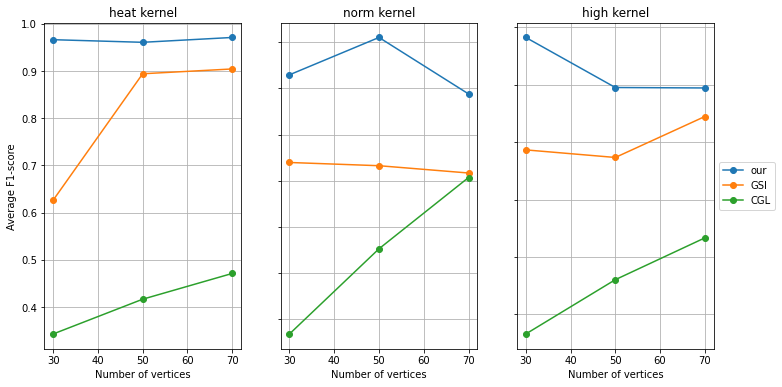

In [40]:
plot_results(f1_avg,"Average F1-score")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


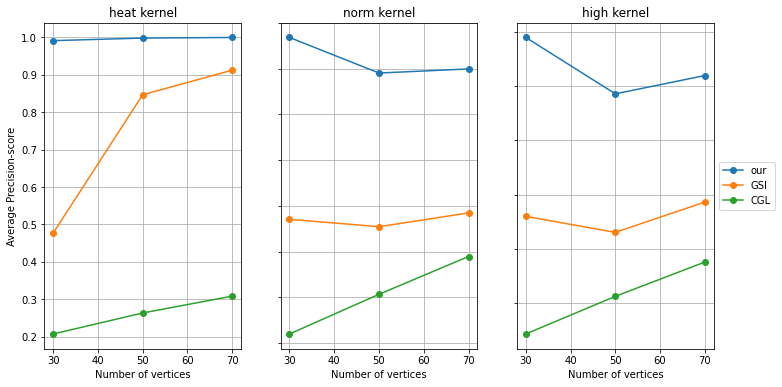

In [41]:
plot_results(precision_avg,"Average Precision-score")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


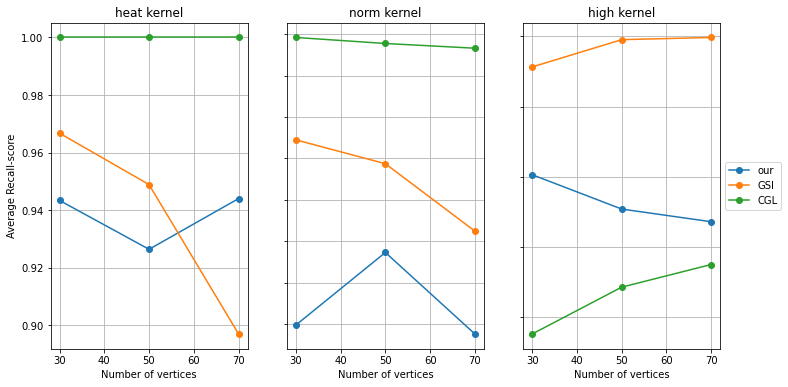

In [42]:
plot_results(recall_avg,"Average Recall-score")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


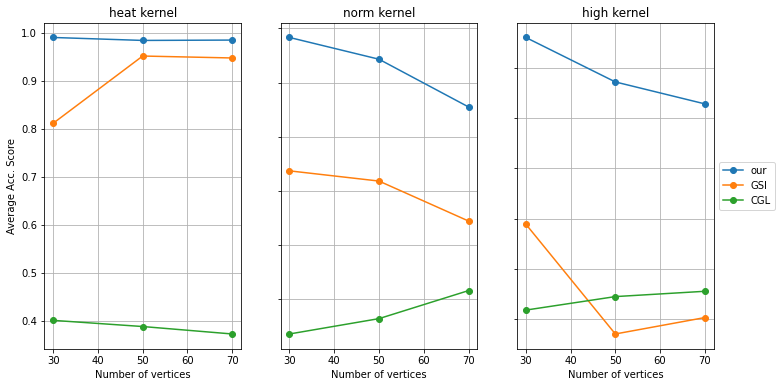

In [43]:
plot_results(acc_avg,"Average Acc. Score")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


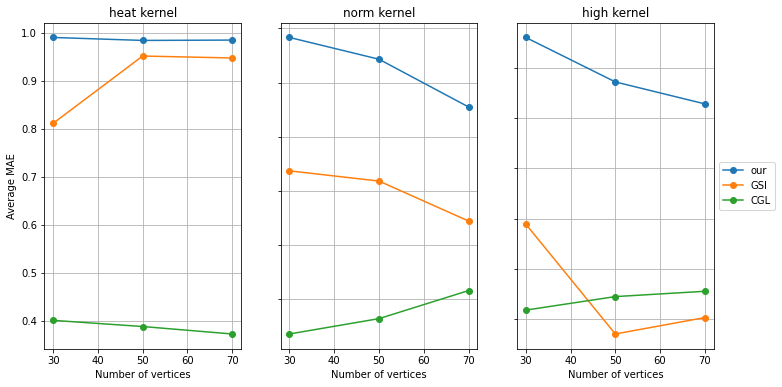

In [44]:
plot_results(mae_avg,"Average MAE")